#LSTM Model For Career

In [2]:
import numpy as np
import pandas as pd
import pickle
from math import pi
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,LSTM,Dropout,Dense,TimeDistributed,Input,Reshape


## Training The Model

In [1]:
#initializing targets
target_list = ['software_developer','senior_software_developer','database_admin','business_analyst','site_reliability_engineer',
               'data_scientist','research_&_development','technical_writer','technical_support','trainer_or_teacher',
               'technical_recruiter','sales_engineer','manager','scrum_master','machine_learning_engineer']

# create the training data
path_list = ["/content/career_data_year-1.csv","/content/career_data_year-2.csv",
             "/content/career_data_year-3.csv","/content/career_data_year-4.csv","/content/career_data_year-5.csv"]


In [3]:
# sample dataframe
df = pd.read_csv(path_list[0])

traindf = pd.DataFrame("", index=range(0,len(df)),columns=df.columns)

for i in range(0,len(path_list)):
  data = pd.read_csv(path_list[i])

  for col in data.columns:
    traindf[col] += data[col]+","

traindf.to_csv("career_training.csv",index=False)


In [4]:
traindf.head()

,Skills,Interest,Workstyle,Best Fit
0,"analytical thinking, flexible, decision makin...","writing, photography,writing, sports,writing, ...","confident, flexible,patient, problem solving,...","scrum master,trainer or teacher,technical recr..."
1,"decision making,sql, decision making, collabo...","origami, sociology,writing, news,writin, driv...","day dream, overtime, repeating tasks, effectiv...","research & development,technical writer,sales ..."
2,"internet applications, algorithms, internet a...","board games, music, cooking, stocks,volunteer...","pressure,pressure, multitasking, pressure, goa...","site reliability engineer,senior software deve..."
3,"analytical thinking, distributed systems, dis...","emerging tech, video games, cooking,video gam...","work stress, multitasking,collaborative, flex...","senior software developer,machine learning eng..."
4,"experience, data mining, experience, analytic...","photography,psychology, writing, sports, mark...","shift work, effective communicative,shift work...","technical recruiter,manager,sales engineer,tec..."


In [5]:
# editing the data
def clean_text(traindf):

  for col in traindf.columns:
    for row in range(len(traindf)):
      traindf.iloc[row][col] = traindf.iloc[row][col].replace(", ", ",")
      
      # remove spaces from both end of string
      traindf.iloc[row][col] = traindf.iloc[row][col].strip(" ")

      # replace " " with "_"
      traindf.iloc[row][col] = traindf.iloc[row][col].replace(" ", "_")
  
  return traindf


In [6]:
traindf = clean_text(traindf)
traindf.head()

,Skills,Interest,Workstyle,Best Fit
0,"analytical_thinking,flexible,decision_making,h...","writing,photography,writing,sports,writing,exp...","confident,flexible,patient,problem_solving,eff...","scrum_master,trainer_or_teacher,technical_recr..."
1,"decision_making,sql,decision_making,collaborat...","origami,sociology,writing,news,writin,driving,...","day_dream,overtime,repeating_tasks,effective_c...","research_&_development,technical_writer,sales_..."
2,"internet_applications,algorithms,internet_appl...","board_games,music,cooking,stocks,volunteering,...","pressure,pressure,multitasking,pressure,goal_o...","site_reliability_engineer,senior_software_deve..."
3,"analytical_thinking,distributed_systems,distri...","emerging_tech,video_games,cooking,video_games,...","work_stress,multitasking,collaborative,flexibl...","senior_software_developer,machine_learning_eng..."
4,"experience,data_mining,experience,analytical_t...","photography,psychology,writing,sports,market_k...","shift_work,effective_communicative,shift_work,...","technical_recruiter,manager,sales_engineer,tec..."


In [7]:
#input consists of skills, interest and workstyle
inp = list()

for hm, lm, wm in zip(traindf['Skills'],traindf['Interest'],traindf['Workstyle']):
  skills = [w for w in hm.split(",")]
  skills.pop(-1)

  interest = [w for w in lm.split(",")]
  interest.pop(-1)

  wstyle = [w for w in wm.split(",")]
  wstyle.pop(-1)

  inp.append(skills + interest + wstyle) 

#output consists of possible targets
best_fit = list()

for m in traindf['Best Fit']:
  fits = [w for w in m.split(",")]
  fits.pop(-1)

  best_fit.append(fits)


In [9]:
MAX_LEN = 40

#inp tokenizer for input data
inp_token = Tokenizer()
inp_token.fit_on_texts(inp)
inp_dict = inp_token.word_index

xseq = inp_token.texts_to_sequences(inp)
xpadseq = pad_sequences(xseq,maxlen=MAX_LEN,padding='post')

#output tokenizer for output data
out_token = Tokenizer()
out_token.fit_on_texts(best_fit)
out_dict = out_token.word_index

yseq = out_token.texts_to_sequences(best_fit)
ypadseq = pad_sequences(yseq,maxlen=MAX_LEN,padding='post')

print([xpadseq[0],ypadseq[0]])


[array([89,  8, 12,  8, 57,  8, 72, 54, 54,  8, 24,  4, 14,  4,  7,  4, 32,
       18, 19, 19,  4,  4,  4,  4,  4, 10,  6,  5,  1,  2, 26,  2, 22, 10,
       22,  6, 30, 40, 30, 21], dtype=int32), array([ 6, 10,  4,  6,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32)]


In [10]:
vocab = len(inp_dict) + 1
num_classes = len(out_dict) + 1

yvec = tf.keras.utils.to_categorical(ypadseq,num_classes=num_classes)

model = tf.keras.models.Sequential([
    Embedding(vocab,256,input_length=MAX_LEN),

    Dropout(0.2),

    LSTM(256,input_shape=(MAX_LEN,1),return_sequences=True),
    LSTM(256,input_shape=(MAX_LEN,1),return_sequences=True),

    TimeDistributed(Dense(units=num_classes,activation=tf.nn.softmax))
])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 256)           28416     
_________________________________________________________________
dropout (Dropout)            (None, 40, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 40, 256)           525312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 16)            4112      
Total params: 1,083,152
Trainable params: 1,083,152
Non-trainable params: 0
_________________________________________________________________


In [11]:
reduced_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    min_lr=1e-9,
    patience=3,
    cooldown=1
)
model.compile(loss="categorical_crossentropy",optimizer='rmsprop',metrics=["accuracy"])

history = model.fit(xpadseq,yvec,epochs=10,callbacks=[reduced_lr],verbose=1,batch_size=8)

Epoch 1/10
63/63 [==============================] - 23s 301ms/step - loss: 0.4450 - accuracy: 0.8637
Epoch 2/10
63/63 [==============================] - 19s 301ms/step - loss: 0.3443 - accuracy: 0.8864
Epoch 3/10
63/63 [==============================] - 19s 301ms/step - loss: 0.3312 - accuracy: 0.8905
Epoch 4/10
63/63 [==============================] - 19s 300ms/step - loss: 0.3191 - accuracy: 0.8935
Epoch 5/10
63/63 [==============================] - 19s 300ms/step - loss: 0.3085 - accuracy: 0.8959
Epoch 6/10
63/63 [==============================] - 19s 306ms/step - loss: 0.2985 - accuracy: 0.8978
Epoch 7/10
63/63 [==============================] - 19s 305ms/step - loss: 0.2925 - accuracy: 0.8992
Epoch 8/10
63/63 [==============================] - 19s 306ms/step - loss: 0.2871 - accuracy: 0.9008
Epoch 9/10
63/63 [==============================] - 19s 309ms/step - loss: 0.2824 - accuracy: 0.9017
Epoch 10/10
63/63 [==============================] - 19s 308ms/step - loss: 0.2780 - accura

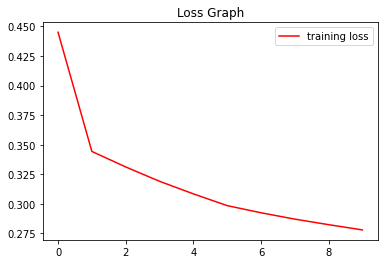

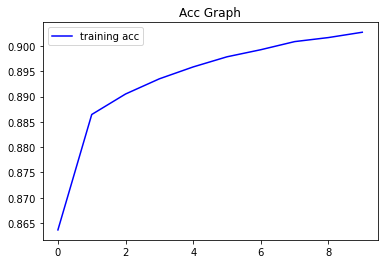

In [12]:
loss = history.history['loss']
acc = history.history['accuracy']

epoch = range(len(loss))

plt.plot(epoch,loss,'r',label='training loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()
plt.plot(epoch,acc,'b',label='training acc')
plt.title('Acc Graph')
plt.legend()
plt.show()


In [13]:
# storing the model parameters
model.save("c_lstm_model.h5")

# input dictionary
dfile = open("c_inp_dict.pkl",'wb')
pickle.dump(inp_dict, dfile)
dfile.close()

# output dictionary
dfile = open("c_out_dict.pkl",'wb')
pickle.dump(out_dict, dfile)
dfile.close()


## Loading model and testing outputs

In [14]:
# loading all the model files
model = tf.keras.models.load_model("/content/c_lstm_model.h5")

dfile = open("/content/c_inp_dict.pkl", "rb")
inp_dict = pickle.load(dfile)

dfile = open("/content/c_out_dict.pkl", "rb")
out_dict = pickle.load(dfile)


In [15]:
year_1 = {
        "Skills": ['distributed systems,business intelligence'],
        "Interest": ['market knowledge, driving, psychology'],
        "Workstyle": ['emotional intelligence, effective communicative']
}

year_2 = {
    "Skills": ['distributed systems,business intelligence,statistics,machine learning,management,c++,c#,c'],
    "Interest": ['market knowledge, driving, psychology,sports, video games, site seeing'],
    "Workstyle": ['emotional intelligence, effective communicative,goal oriented, problem solving,patient, confident']
}

test_list = [year_1,year_2]


In [63]:
def get_modified_list(test_list):
  modified_list = list()

  return modified_list


In [16]:
def predict_output(test_list):
  MAX_LEN = 50

  test_output = list()

  for test_case in test_list:
    # creating testing text
    testdf = pd.DataFrame(test_case)

    testdf = clean_text(testdf)

    # encoding new text with inp dictionary
    testinp = list()

    for hm, lm, wm in zip(testdf['Skills'],testdf['Interest'],testdf['Workstyle']):
      skills = [w for w in hm.split(",")]
      skills.pop(-1)

      istyle = [w for w in lm.split(",")]
      istyle.pop(-1)

      wstyle = [w for w in wm.split(",")]
      wstyle.pop(-1)

      testinp.append(skills + istyle + wstyle) 

    # initializing the tokenizer with pre-built dictionary
    test_token = Tokenizer()
    test_token.word_index = inp_dict
    xseq = test_token.texts_to_sequences(testinp)
    xpadseq = pad_sequences(xseq,maxlen=MAX_LEN,padding='post')

    # predicting the output
    predicted = model.predict(xpadseq)
    final_list = list()

    for i in range(len(predicted)):
      res = list()
      pred = np.round( np.argmax(predicted[i],axis=1) )

      for w in pred:
        for word, index in out_dict.items():
          if index == w:
            res.append(word)
            break
        
      final_list.append(res)

    test_output.append(final_list)

  return test_output


In [17]:
def get_visualization(final_list,target_list):
  #fig, axs = plt.subplots(ncols=len(final_list), figsize=(40,10))

  for final in final_list:
    # the score dictionary
    score_dict = dict()

    N = len(target_list)

    for fit in target_list:
      score_dict[fit] = 0

    for fit in final[0]:
      for key in score_dict.keys():
        if key == fit:
          score_dict[key] += 1    

    angles = [n / float(N) * 2 * pi for n in range(N)]

    values = list(score_dict.values())
    categories = list(score_dict.keys())

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles, categories, color='black', size=8)

    max_idx = max(score_dict, key=score_dict.get)
    max_value = score_dict[max_idx]

    ax.set_rlabel_position(0)
    plt.yticks(list( range(0,(max_value + 1)) ), [str(n) for n in list( range(0,(max_value + 1)) )], color="black", size=10)
    plt.ylim(0,max_value)

    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)

    plt.show()


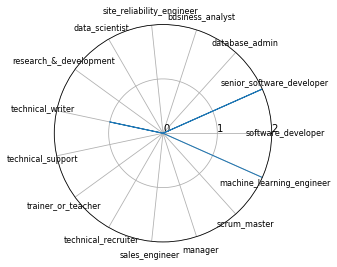

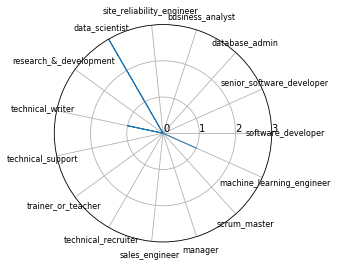

In [18]:
pred_list = predict_output(test_list)
get_visualization(pred_list,target_list)
